In [1]:
import os
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import myutils
import my_models
from keras.models import Sequential, clone_model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import image_dataset_from_directory, img_to_array
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageOps
from IPython.display import display

importlib.reload(myutils)  # reload the module so changes are applied 
importlib.reload(my_models)  # reload the module so changes are applied 

<module 'my_models' from '/Users/wesleychou/Documents/GitHub/crack-detection/my_models.py'>

In [2]:
SIZE = (32, 32)    # image size
INPUT_SHAPE = (SIZE[0], SIZE[1], 1)  # input shape for CNNs
LR = 0.001    # learning rate
EPC = 10    # epochs

Original dataset consists of two folders, each with 15,000 images. It is obtained from https://www.kaggle.com/datasets/oluwaseunad/concrete-and-pavement-crack-images/code.

I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. 

They are stored in the `negative` and `positive` folders, under `sample-data`. Negative images have no cracks. Positive images have cracks.
Let's take a look at the images.

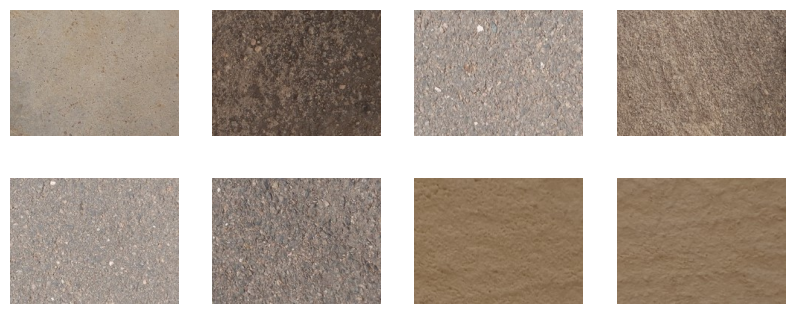

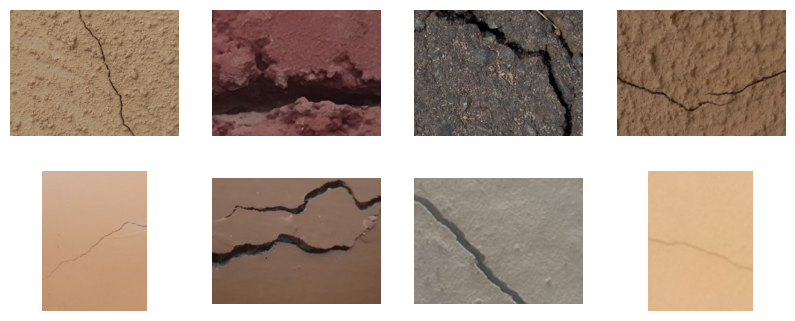

In [3]:
# load images as PIL images
images = shuffle(myutils.load_images('sample-data/negative')) \
    + shuffle(myutils.load_images('sample-data/positive'))

# display the first 8 negative images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")
    
# display the first 8 positive images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i+1000])
    ax.axis("off")

Now we grayscale and resize the images.

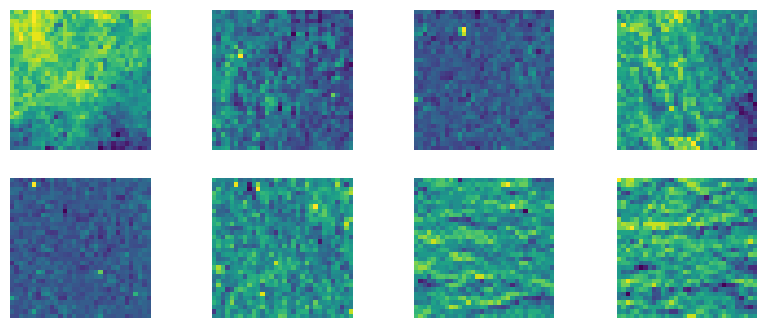

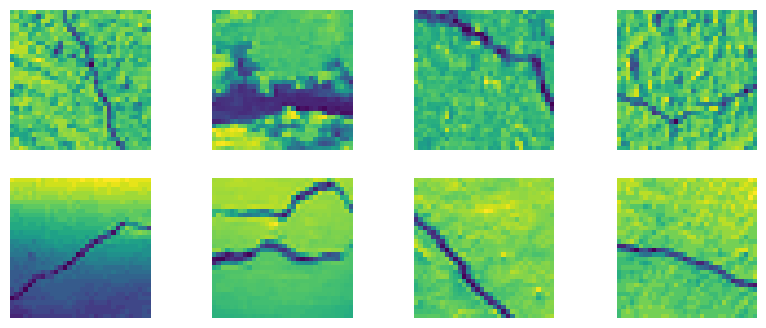

In [4]:
# grayscale and resize the PIL images
images = myutils.grayscale_resize(images, SIZE)

# display the first 8 negative images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")
    
# display the first 8 positive images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i+1000])
    ax.axis("off")

Now we convert the images into numpy arrays. We then normalize the values and shuffle it.

In [5]:
# change PIL images to numpy arrays
X = np.zeros((2000, SIZE[0], SIZE[1]))
y = np.zeros((2000,))

for i, img in enumerate(images):
    X[i] = img_to_array(img).reshape(SIZE)
    y[i] = (0 if i < 1000 else 1)

# normalize image data
X = X / 255.0

# shuffle in unison
X, y = shuffle(X, y, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
X[0][0]

X shape: (2000, 32, 32)
y shape: (2000,)


array([0.01960784, 0.01568627, 0.03137255, 0.1254902 , 0.25490196,
       0.21568627, 0.21960784, 0.2745098 , 0.22352941, 0.25098039,
       0.28627451, 0.29019608, 0.2745098 , 0.2745098 , 0.26666667,
       0.2745098 , 0.40392157, 0.25882353, 0.2745098 , 0.30196078,
       0.32941176, 0.2745098 , 0.2627451 , 0.29411765, 0.29411765,
       0.25098039, 0.24313725, 0.2745098 , 0.30588235, 0.29019608,
       0.25490196, 0.26666667])

Now we split the data into training, cross-validation, and testing sets using a 60-20-20 ratio.

In [6]:
# split data into train, cross-validation, and test
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 32, 32)
y train: (1200,)
X cv: (400, 32, 32)
y cv: (400,)
X test: (400, 32, 32)
y test: (400,)


Let's take a look at the images in our training set.

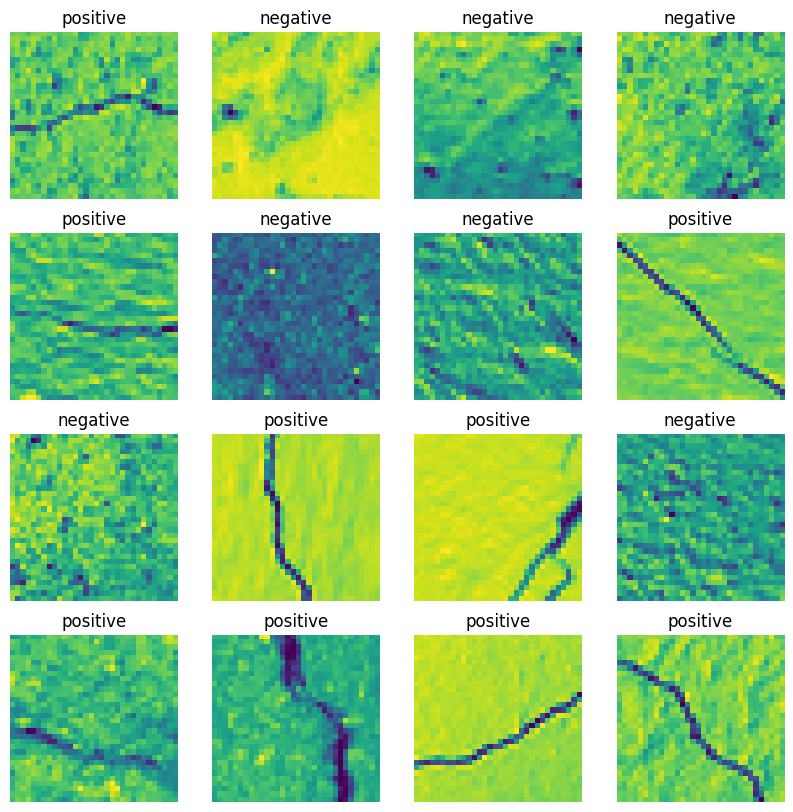

In [7]:
# display the first 16 images in training set
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(SIZE))
    ax.axis("off")
    ax.set_title("positive" if y_train[i]>0 else "negative")

Now we define the model.

In [8]:
# create model
tf.random.set_seed(42)

model = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

2023-04-15 10:15:26.784927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
tf.keras.backend.clear_session()

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

Epoch 1/10
38/38 [==============================] - 2s 19ms/step - loss: 0.6800 - accuracy: 0.5817 - val_loss: 0.6318 - val_accuracy: 0.7475
Epoch 2/10
38/38 [==============================] - 1s 14ms/step - loss: 0.5107 - accuracy: 0.7733 - val_loss: 0.5315 - val_accuracy: 0.7400
Epoch 3/10
38/38 [==============================] - 1s 14ms/step - loss: 0.4466 - accuracy: 0.8150 - val_loss: 0.4065 - val_accuracy: 0.8350
Epoch 4/10
38/38 [==============================] - 1s 19ms/step - loss: 0.3901 - accuracy: 0.8475 - val_loss: 0.3930 - val_accuracy: 0.8250
Epoch 5/10
38/38 [==============================] - 1s 15ms/step - loss: 0.3841 - accuracy: 0.8400 - val_loss: 0.3654 - val_accuracy: 0.8475
Epoch 6/10
38/38 [==============================] - 1s 14ms/step - loss: 0.3752 - accuracy: 0.8475 - val_loss: 0.3722 - val_accuracy: 0.8475
Epoch 7/10
38/38 [==============================] - 1s 14ms/step - loss: 0.3544 - accuracy: 0.8567 - val_loss: 0.3989 - val_accuracy: 0.8475
Epoch 8/10
38

Evaluate model

Evaluation with cross-validation dataset:

loss = 0.33257535099983215
accuracy = 0.8575000166893005


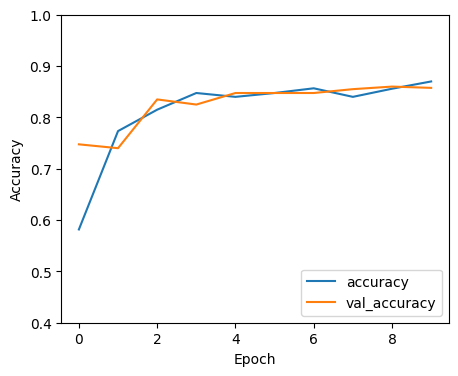

In [10]:
fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
print(f"loss = {cv_loss}\naccuracy = {cv_acc}")

Let's try creating different models and test them out.

In [11]:
tf.keras.backend.clear_session()

mymodels = my_models.MyModels()

# model 1 (this is the original model)
model_1 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_1", model_1)

# model 2
model_2 = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_2", model_2)

# model 3
model_3 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_3", model_3)

# model 4
model_4 = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_4", model_4)

mymodels.print_models()

['model_1', 'model_2', 'model_3', 'model_4']


In [ ]:
# mymodels.del_all_models()
# mymodels.print_models()

Evaluate models.


Cross validation metrics:

model_1:
	loss = 0.30793941020965576
	accuracy = 0.8675000071525574
model_2:
	loss = 0.23881791532039642
	accuracy = 0.9024999737739563
model_3:
	loss = 0.3096517026424408
	accuracy = 0.8999999761581421
model_4:
	loss = 0.2844097912311554
	accuracy = 0.8799999952316284


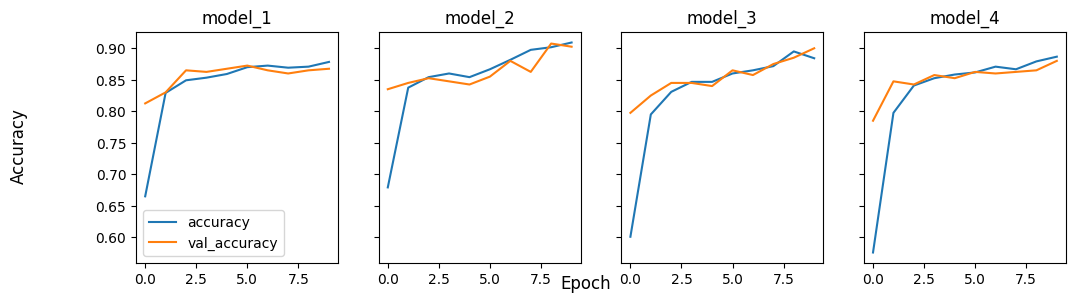

In [12]:
print("\nCross validation metrics:\n")
mymodels.run_and_evaluate(X_train, y_train, X_cv, y_cv, LR, EPC)

We will choose model 2 for its higher accuracy and lower loss.

In [13]:
preferred = "model_2"

model = mymodels.get_model(preferred)
model.summary()

model.save_weights('model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

Hyperparameter Tuning

Lets try out different learning rates.

Cross validation metrics:

Learning rate = 0.1
	loss = 0.695740282535553
	accuracy = 0.47999998927116394
Learning rate = 0.01
	loss = 0.2878289222717285
	accuracy = 0.8924999833106995
Learning rate = 0.001
	loss = 0.24009555578231812
	accuracy = 0.8999999761581421
Learning rate = 0.0001
	loss = 0.40106305480003357
	accuracy = 0.8424999713897705


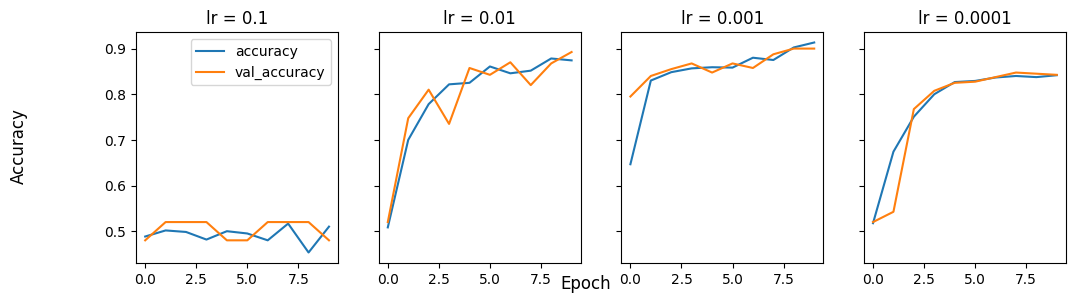

In [14]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]  # different learning rate values

fig, axes = plt.subplots(ncols=len(learning_rates), figsize=(12,3), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')

print("Cross validation metrics:\n")

for i, lr in enumerate(learning_rates):

    # reset the model weights
    test_model = clone_model(model)
    
    test_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    history = test_model.fit(X_train, y_train, epochs=EPC, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    axes[i].set_title(f"lr = {lr}")
    axes[i].plot(history.history['accuracy'], label='accuracy')
    axes[i].plot(history.history['val_accuracy'], label = 'val_accuracy')
    if i==0: axes[i].legend()

    cv_loss, cv_acc = test_model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")
    

We can see that the ideal learning rate is somewhere between 0.01 and 0.0001. Let's find that ideal learning rate. The code below will take a while to run.

In [15]:
test_model = clone_model(model)

test_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(), # default learning rate (0.001)
    metrics=['accuracy']
)

test_history = test_model.fit(X_train, y_train, epochs=100, validation_data=(X_cv, y_cv),
    callbacks=[ 
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 0.01 * 10**(-epoch/100)  # 0.01 to 0.0001
        )
    ]
)

Epoch 1/100
38/38 [==============================] - 2s 29ms/step - loss: 0.6992 - accuracy: 0.5325 - val_loss: 0.6624 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/100
38/38 [==============================] - 1s 25ms/step - loss: 0.5846 - accuracy: 0.6792 - val_loss: 0.5710 - val_accuracy: 0.6900 - lr: 0.0098
Epoch 3/100
38/38 [==============================] - 1s 27ms/step - loss: 0.5380 - accuracy: 0.7317 - val_loss: 0.4346 - val_accuracy: 0.8150 - lr: 0.0095
Epoch 4/100
38/38 [==============================] - 1s 24ms/step - loss: 0.4228 - accuracy: 0.8042 - val_loss: 0.4194 - val_accuracy: 0.8225 - lr: 0.0093
Epoch 5/100
38/38 [==============================] - 1s 25ms/step - loss: 0.4239 - accuracy: 0.8175 - val_loss: 0.3957 - val_accuracy: 0.8300 - lr: 0.0091
Epoch 6/100
38/38 [==============================] - 1s 27ms/step - loss: 0.4000 - accuracy: 0.8342 - val_loss: 0.4549 - val_accuracy: 0.8150 - lr: 0.0089
Epoch 7/100
38/38 [==============================] - 1s 24ms/step - lo

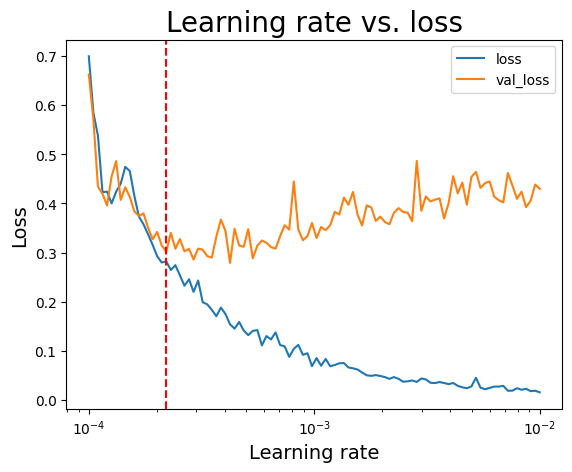

In [22]:
learning_rates = np.logspace(-4, -2, num=100)
plt.semilogx(
    learning_rates, 
    test_history.history['loss'], 
    label='loss'
)
plt.semilogx(
    learning_rates, 
    test_history.history['val_loss'], 
    label='val_loss'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.legend()

# red vertical line at learning rate = 10^-3.65 (approx. 0.00022)
plt.axvline(x=0.00022, color='red', linestyle='--')

A learning rate of 10^-3.65, or about 0.00022 seems good. Let's train the model with this learning rate.

In [ ]:
# new learning rate
LR = 0.00022

test_model = clone_model(model)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

Ways to improve model:

**MUST DO!**
1. filter images to make crack more obvious    <------ THIS!!!
2. try diff models
    - add/remove layers, increase/decrease neurons
    - regularization like L1 or L2
    - dropout layers
3. tuning hyperparameters like learning rate

Let's try increasing the number of epochs.

In [ ]:
EPC = 50    # used to be 10

# reset model
model = myutils.create_model(INPUT_SHAPE)

model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
        metrics=['accuracy']
    )
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see that both `accuracy` and `val_accuracy` oscillates up and down. This indicates an overfitting of data. We will try regularization techniques